# Rapid prototyping of fMRI models with `brainiak.matnormal`

Michael Shvartsman [m.shvartsman.work@gmail.com](mailto://m.shvartsman.work@gmail.com)

## Table of contents
- [Overview: understanding Kronecker-separability](#Overview)
- [Example 1: regression](#regression)
- [Example 2: marginalization and RSA](#MN-RSA)
- [Example 3: design matrices: PCA and FA](#latent-design)
- [Summary and future outlook](#Summary)

<a id="Overview"></a>
## Overview: Understanding kronecker-separability

Unlike many of the other tools in `brainiak`, the `brainiak.matnormal` package is only a little bit about specific methods and a lot about letting you try new ideas and method variants quickly. If the variants are useful, they can be sped up and made neater for broader consumption. To understand the idea behind matrix-normal or kronecker-separable models, consider the following figure: 

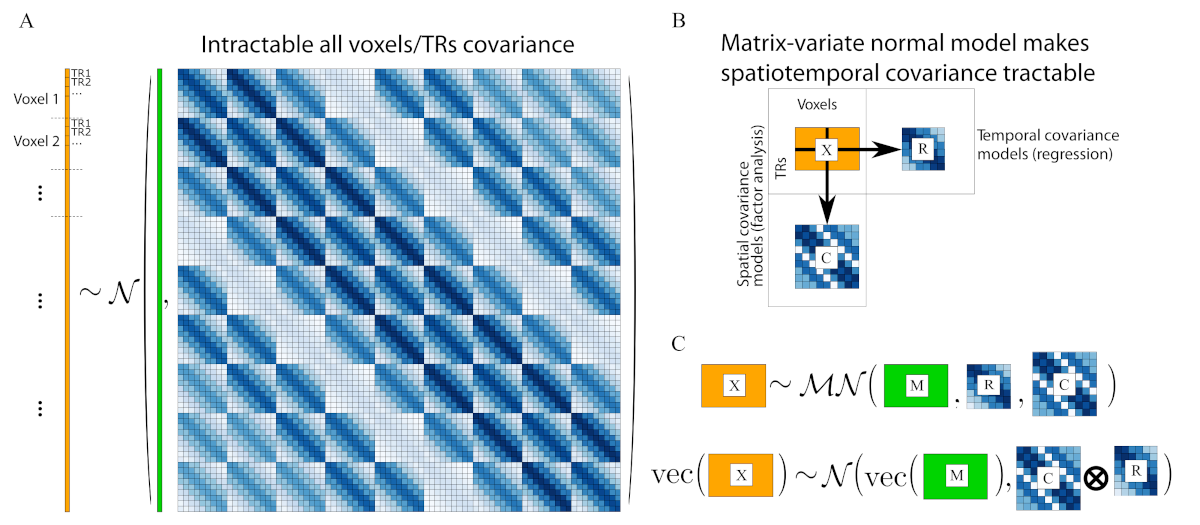

**Matrix normal models simultaneously model spatial and temporal residuals.** \[A\]: a schematic view of a vectorized data matrix, where each voxel's time series is vertically concatenated (in orange), and the covariance of every voxel at every timepoint with every other voxel at every other timepoint is modeled. Modeling all of these elements independently is intractable, and some structure needs to be imposed -- in this case, kronecker-separable structure. \[B\]: the un-vectorized data matrix (orange rectangle), and its spatial and temporal covariances on the right and bottom. \[C\]: A matrix-normal distribution with the mean M and row/column covariances R, C is equivalent to the large structure in \[A\], but can be much more tractable to estimate. Figure and caption reused under CC-BY-NC-ND from doi:[10.1016/j.neuropsychologia.2020.107500](https://doi.org/10.1016/j.neuropsychologia.2020.107500). 


# Annotated Bibliography 

Shvartsman, M., Sundaram, N., Aoi, M., Charles, A., Willke, T. L., & Cohen, J. D. (2018). Matrix-normal models for fMRI analysis. *International Conference on Artificial Intelligence and Statistics, AISTATS 2018*, 1914–1923. Extended version available at [`link`](https://arxiv.org/abs/1711.03058) *Describes how to formulate a number of common fMRI analysis methods available in `BrainIAK` as matrix-normal models, and shows some benefits of this formulation.*

Cai, M. B., Shvartsman, M., Wu, A., Zhang, H., & Zhu, X. (2020). Incorporating structured assumptions with probabilistic graphical models in fMRI data analysis. *Neuropsychologia*, 144, 1–23. [`link`](https://doi.org/10.1016/j.neuropsychologia.2020.107500) *Provides an alternate framing of the matrix normal model focusing on the modeling of structured residuals.*


Magnus, J. R., & Neudecker, H. (1988). Matrix differential calculus with applications in statistics and econometrics. *This is the standard reference for matrix calculus. A summary of some important identities may also be found on Wikipedia at [`link`](https://en.wikipedia.org/wiki/Matrix_calculus#Identities_in_differential_form).*


Katanoda, K., Matsuda, Y., & Sugishita, M. (2002). A spatio-temporal regression model for the analysis of functional MRI data. *NeuroImage*, 17(3), 1415–1428. [`link`](https://doi.org/10.1006/nimg.2002.1209) *Example of a regression model for fMRI with separable residuals.*

Hartvig, N. V. (2002). A stochastic geometry model for functional magnetic resonance images. *Scandinavian Journal of Statistics*, 29(3), 333–353. [`link`](https://doi.org/10.1111/1467-9469.00294) *Example of a separable residual covariance to a spatial activation model for fMRI data.*

Kia, S. M., Beckmann, C. F., & Marquand, A. F. (2018). Scalable multi-task gaussian process tensor regression for normative modeling of structured variation in neuroimaging data. Retrieved from [`link`](http://arxiv.org/abs/1808.00036) *Example of using tensor regression models for analyzing fMRI data.*


<a id='regression'></a>
## Example 1: Matrix-normal (separable-covariance) regression
To understand how simple it is to prototype new matrix-normal models, consider first simple linear regression: 

$$
Y \sim \mathcal{MN}(XB, I, I), 
$$

where $Y$ is a centered TRs by voxels matrix of brain data, $X$ is a TRs by conditions design matrix, and $B$ is a conditions by voxels coefficients matrix. Notated this way, the model is the conventional massively-univariate GLM: the activation at every voxel and every timepoint is a linear combination (aka weighted sum) of the condition coding, weighted by the coefficients -- or equivalently a weighted sum of the coefficients, with the condition codes as weights. We can generate a simple dataset and show how simple it is to fit such a model by maximum likelihood using automatically computed gradients. 

In [1]:
# General imports and setup
import numpy as np
import scipy.linalg
from numpy.linalg import cholesky
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import expit as inv_logit
from scipy.stats import norm, pearsonr

from sklearn.datasets import make_friedman1
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

np.random.seed(1)
tf.random.set_seed(1)
sns.set_theme()

# brainiak.matnormal.covs provides implementations of various
# structured covariances. We will discuss this shortly.
from brainiak.matnormal.covs import (
    CovAR1,
    CovDiagonal,
    CovDiagonalGammaPrior,
    CovIdentity,
    CovUnconstrainedCholesky,
)

# brainiak.matnormal.matnormal_likelihoods provides efficient implementations
# of matrix-normal likelihoods, including marginals and conditionals
from brainiak.matnormal.matnormal_likelihoods import (
    matnorm_logp,
    matnorm_logp_marginal_row,
    matnorm_logp_marginal_col,
)

# brainiak.matnormal provides implementations of MN variants of some existing analyses
from brainiak.matnormal.mnrsa import MNRSA
from brainiak.matnormal.regression import MatnormalRegression

# brainiak.matnormal.utils provides helpers that (mostly) make it easy
# to interface between tensorflow and scipy optimizers
from brainiak.matnormal.utils import (
    make_val_and_grad,
    pack_trainable_vars,
    rmn,
    unpack_trainable_vars,
)

# this is used in the MNRSA example
from brainiak.utils.utils import cov2corr

<IPython.core.display.Javascript object>

In [2]:
# Generate data
conditions = 5
voxels = 100
TRs = 50

X, _ = make_friedman1(n_samples=TRs, n_features=conditions, random_state=None)
B = 2 * np.random.random(size=(conditions, voxels))  # pretty generous SNR of 2
Y = X @ B + np.random.normal(size=(TRs, voxels))

<IPython.core.display.Javascript object>

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
True and estimated B correlation: 0.78999786325132


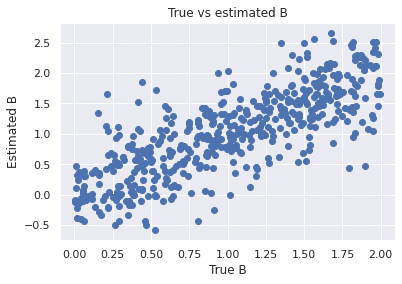

<IPython.core.display.Javascript object>

In [3]:
# Now we create the tensorflow objects we need. The covariances are independent
# since this is the univariate GLM.
space_cov = CovIdentity(size=voxels)
time_cov = CovIdentity(size=TRs)

# this is our estimate of B, and the wrappers for X and Y.
B_hat = tf.Variable(np.random.normal(size=(conditions, voxels)), name="beta")
Y_tf = tf.constant(Y)
X_tf = tf.constant(X)
# construct loss (negative log likelihood)
# note that params are ignored by this function but implicitly
# tracked by tensorflow to compute gradients
def loss(params):
    return -matnorm_logp(Y_tf - X_tf @ B_hat, time_cov, space_cov)


val_and_grad = make_val_and_grad(lossfn=loss, train_vars=[B_hat])
initial_guess = pack_trainable_vars([B_hat])
opt_results = minimize(fun=val_and_grad, x0=initial_guess, jac=True, method="L-BFGS-B")
print(opt_results.message)  # check that we converged

_ = B_hat.assign(unpack_trainable_vars(opt_results.x, trainable_vars=[B_hat])[0])

plt.plot(B.flatten(), B_hat.numpy().flatten(), "bo")
plt.xlabel("True B")
plt.ylabel("Estimated B")
plt.title("True vs estimated B")
print(
    f"True and estimated B correlation: {pearsonr(B_hat.numpy().flatten(), B.flatten())[0]}"
)

In practice, a simple model like this could just as easily be fit using more standard tools. More interesting is if we (reasonably) assume that the noise in our data is structured, and we want to model that structure rather than try to prewhiten it, for example:

$$
\sigma_v^{-1} \sim \mathcal{InvGamma}(\alpha, \beta)\\
Y \sim \mathcal{MN}(XB, \Sigma_{AR1},\mathrm{diag}(\sigma_v)), 
$$

where $\Sigma_{AR1}$ is a structured covariance matrix with AR(1) structure, and the spatial covariance is diagonal (independent) but with varying scales for each voxel and we use an inverse-gamma prior to regularize them. Estimating this model is very similar: 

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
True and estimated B correlation: 0.7891954003335606


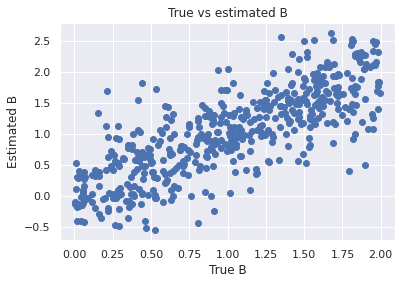

<IPython.core.display.Javascript object>

In [4]:
# generate AR(1) temporal noise that is independent in space
true_time_cov = CovAR1(size=TRs)
true_space_cov = CovDiagonalGammaPrior(size=voxels)
noise = rmn(rowcov=true_time_cov._cov, colcov=true_space_cov._cov)
Y = X @ B + noise

# This time space_cov is AR(1)
space_cov = CovDiagonalGammaPrior(size=voxels)
time_cov = CovAR1(size=TRs)

# Reset B_hat
B_hat = tf.Variable(np.random.normal(size=(conditions, voxels)), name="beta")

# Now we estimate B_hat, but also the AR parameters and the
# voxelwise residual variances (which the relevant
# cov objects know about and expose to us)
train_vars = [B_hat] + time_cov.get_optimize_vars() + space_cov.get_optimize_vars()

# now this loss incorporates the log-likelihood of our covariance parameters
def loss(params):
    return (
        -matnorm_logp(Y_tf - X_tf @ B_hat, time_cov, space_cov)
        - space_cov.logp
        - time_cov.logp
    )


val_and_grad = make_val_and_grad(lossfn=loss, train_vars=train_vars)
initial_guess = pack_trainable_vars(train_vars)
opt_results = minimize(fun=val_and_grad, x0=initial_guess, jac=True, method="L-BFGS-B")
print(opt_results.message)  # check that we converged

# assign the AR parameters as well as B
unpacked_theta = unpack_trainable_vars(opt_results.x, trainable_vars=train_vars)
for var, val in zip(train_vars, unpacked_theta):
    var.assign(val)


plt.plot(B.flatten(), B_hat.numpy().flatten(), "bo")
plt.xlabel("True B")
plt.ylabel("Estimated B")
plt.title("True vs estimated B")
print(
    f"True and estimated B correlation: {pearsonr(B_hat.numpy().flatten(), B.flatten())[0]}"
)

`brainiak.matnormal` provides a convenience wrapper for such regression models (as `MatnormalRegression`). 

True an estimated B correlation (MN): 0.6194865860962584


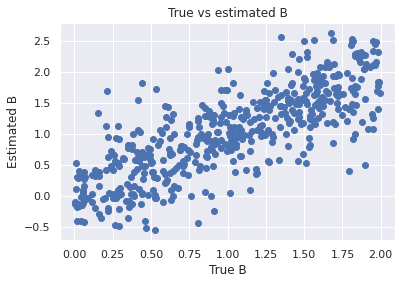

<IPython.core.display.Javascript object>

In [5]:
model = MatnormalRegression(time_cov=time_cov, space_cov=space_cov)
model.fit(X, Y, naive_init=False)
plt.plot(B.flatten(), B_hat.numpy().flatten(), "bo")
plt.xlabel("True B")
plt.ylabel("Estimated B")
plt.title("True vs estimated B")
print(
    f"True an estimated B correlation (MN): {pearsonr(model.beta_.flatten(), B.flatten())[0]}"
)

The covariance-modeling approach should work better than either ignoring covariance structure in the data, or pre-whitening by dividing out the correlations. So we now compare to both of those approaches on the same synthetic dataset. 

True and estimated B correlation (MN): 0.6194865860962584
True and estimated B correlation (GLM, ignore cov): 0.38985685962097216
True and estimated B correlation (GLM, prewhiten cov): 0.5315137290009893


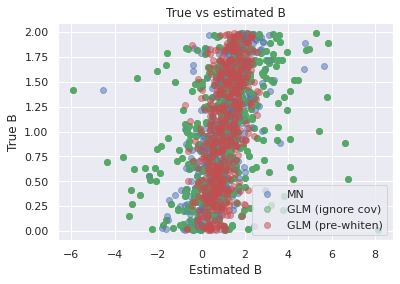

<IPython.core.display.Javascript object>

In [6]:
glm_ignore_cov = LinearRegression()
glm_ignore_cov.fit(X, Y)
plt.plot(glm_ignore_cov.coef_.T.flatten(), B.flatten(), "go")

# prewhiten
W = np.linalg.cholesky(np.cov(Y))
Y_whitened = np.linalg.solve(W, Y)
X_whitened = np.linalg.solve(W, X)
coef_whitened = np.linalg.solve(X_whitened.T @ X_whitened, X_whitened.T @ Y_whitened)
glm_whitened = LinearRegression()
glm_whitened.fit(X_whitened, Y_whitened)

plt.plot(model.beta_.flatten(), B.flatten(), "bo", label="MN", alpha=0.5)
plt.plot(
    glm_ignore_cov.coef_.T.flatten(),
    B.flatten(),
    "go",
    label="GLM (ignore cov)",
    alpha=0.5,
)
plt.plot(
    glm_whitened.coef_.T.flatten(),
    B.flatten(),
    "ro",
    label="GLM (pre-whiten)",
    alpha=0.5,
)
plt.legend()
plt.ylabel("True B")
plt.xlabel("Estimated B")
plt.title("True vs estimated B")
print(
    f"True and estimated B correlation (MN): {pearsonr(model.beta_.flatten(), B.flatten())[0]}"
)
print(
    f"True and estimated B correlation (GLM, ignore cov): {pearsonr(glm_ignore_cov.coef_.T.flatten(), B.flatten())[0]}"
)
print(
    f"True and estimated B correlation (GLM, prewhiten cov): {pearsonr(glm_whitened.coef_.T.flatten(), B.flatten())[0]}"
)

## Example 2: Priors and marginalization, with MN-RSA
<a id='mn-rsa'></a>
We have already introduced the idea of priors in the previous example, though in that case we were using them purely as regularization. But we can sometimes set priors in a way that lets us integrate over some nuisance parameter entirely. This marginalization is used, for example, in deriving BRSA from beta-series RSA (also available in `brainiak`). We notate the same marginalization in the matrix-normal setting next. If: 

$$
B \sim \mathcal{MN}(0, U, I)\\
Y \mid B \sim \mathcal{MN}(XB, \Sigma_{AR1},I), 
$$
then:
$$
Y \sim \mathcal{MN}(0, XUX^{T} + \Sigma_{AR1},I), 
$$

and the RSA correlation is given by dividing the RSA covariance $U$ by the featurewise variances. BRSA relies on a number of linear algebra tricks to speed up estimation, and similar tricks for the matrix-normal setting are availble in generalized form to enable MN-RSA. A more extended example is available at the [MN-RSA example notebook](https://github.com/brainiak/brainiak/blob/master/examples/reprsimil/bayesian_rsa_example.ipynb) shipped with `brainiak`: 

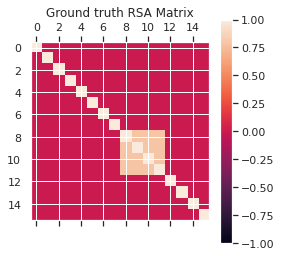

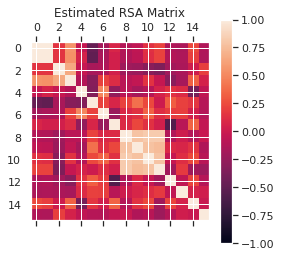

<IPython.core.display.Javascript object>

In [7]:
# make a fake RSA matrix
conditions = 16
groundtruth_U = np.zeros([conditions, conditions])
groundtruth_U = np.eye(conditions) * 0.6
groundtruth_U[8:12, 8:12] = 0.8
for cond in range(8, 12):
    groundtruth_U[cond, cond] = 1
groundtruth_C = cov2corr(groundtruth_U)
plt.matshow(groundtruth_C, vmin=-1, vmax=1)
plt.title("Ground truth RSA Matrix")
plt.colorbar()

# synthetic data
B = rmn(groundtruth_U, space_cov._cov) # now B is RSA-structured, rest is as above
X, _ = make_friedman1(n_samples=TRs, n_features=conditions, random_state=None)
noise = rmn(rowcov=true_time_cov._cov,  colcov=true_space_cov._cov)
Y = X @ B + noise

rsa_cov = CovUnconstrainedCholesky(size=conditions)

params = (
    rsa_cov.get_optimize_vars()
    + time_cov.get_optimize_vars()
    + space_cov.get_optimize_vars()
)

# note the loss now includes a marginal logp term, plus the likelihoods of the various covariances in question
def loss(params):
    return -(
        time_cov.logp
        + space_cov.logp
        + rsa_cov.logp
        + matnorm_logp_marginal_row(
            Y, row_cov=time_cov, col_cov=space_cov, marg=X, marg_cov=rsa_cov
        )
    )

val_and_grad = make_val_and_grad(lossfn=loss, train_vars=params)

x0 = pack_trainable_vars(params)

opt_results = minimize(fun=val_and_grad, x0=x0, jac=True, method="L-BFGS-B")

fit_params = unpack_trainable_vars(opt_results.x, params)

for var, val in zip(params, fit_params):
    var.assign(val)

U = rsa_cov._cov.numpy()
C = cov2corr(U)
plt.matshow(C, vmin=-1, vmax=1)
plt.title("Estimated RSA Matrix")
plt.colorbar()


As before, this model is available in `brainiak` directly as `MNRSA`, where it incorporates nuisance regressors as well: 

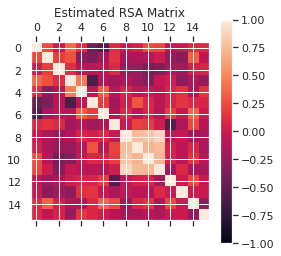

<IPython.core.display.Javascript object>

In [8]:
model_matnorm = MNRSA(time_cov=time_cov, space_cov=space_cov, n_nureg=3)

model_matnorm.fit(Y, X)
plt.matshow(model_matnorm.C_, vmin=-1, vmax=1)
plt.title("Estimated RSA Matrix")
plt.colorbar()

<a id='latent-design'></a>
## Example 3: latent design matrices with PCA and FA
The true benefit of a shared framework comes when starting to see the commonalities among methods. For example, consider what happens if the known design matrix $X$ is replaced with an unknown latent time series $S$, yielding the following model: 

$$
Y \sim \mathcal{MN}(SB, I, I). 
$$

In this model, we no longer know the design matrix, and the brain volume is now a weighted sum of unknown time series, with unknown weights. It turns out that this is precisely the model for probabilistic PCA, and there is nothing stopping us from implementing it in our framework. However, note that PCA has uniquely many solutions, so while doing naive gradient descent on this problem might work in toy examples, it isn't a particularly realistic example. To find a unique solution, we can integrate over either $S$ or $B$ using a matrix-normal prior. We choose to integrate over $S$, since it is a larger matrix in this case and this lets us estimate fewer parameters. 

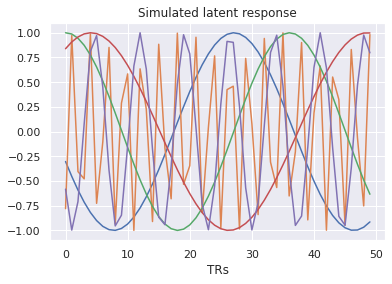

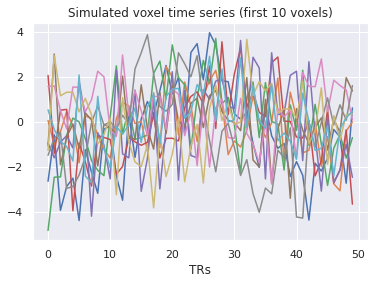

<IPython.core.display.Javascript object>

In [9]:
# Generate data
components = 5
voxels = 100
TRs = 50

S = np.sin(
    np.arange(TRs)[:, None] @ np.random.randn(1, components)
    + np.random.randn(1, components)
)
plt.plot(S)  # random sinewaves with noise
plt.title("Simulated latent response")
plt.xlabel("TRs")
B = np.random.randn(components, voxels)
Y = S @ B + np.random.randn(TRs, voxels)
plt.figure()

plt.plot(Y[:, :10])
plt.xlabel("TRs")
_ = plt.title("Simulated voxel time series (first 10 voxels)")

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


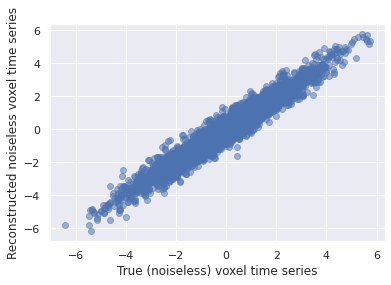

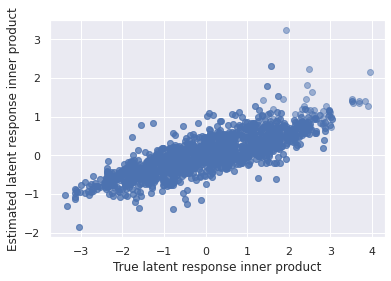

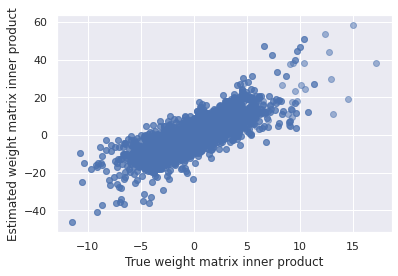

<IPython.core.display.Javascript object>

In [10]:
# generate AR(1) temporal noise that is independent in space
true_time_cov = CovIdentity(size=TRs)
true_space_cov = CovIdentity(size=voxels)
noise = rmn(rowcov=true_time_cov._cov, colcov=true_space_cov._cov)
Y_tf = tf.constant(S @ B + noise)

# This time space_cov is AR(1)
space_cov = CovDiagonalGammaPrior(size=voxels)
time_cov = CovAR1(size=TRs)
marg_cov = CovIdentity(size=components)

# B_hat
B_hat = tf.Variable(np.random.normal(size=(components, voxels)), name="beta")

train_vars = [B_hat] + time_cov.get_optimize_vars() + space_cov.get_optimize_vars()

# now this loss incorporates the log-likelihood of our covariance parameters
def loss(params):
    return (
        -matnorm_logp_marginal_col(Y_tf, time_cov, space_cov, B_hat, marg_cov)
        - space_cov.logp
        - time_cov.logp
    )


val_and_grad = make_val_and_grad(lossfn=loss, train_vars=train_vars)
initial_guess = pack_trainable_vars(train_vars)
opt_results = minimize(fun=val_and_grad, x0=initial_guess, jac=True, method="L-BFGS-B")
print(opt_results.message)  # check that we converged

# assign the parameters
unpacked_theta = unpack_trainable_vars(opt_results.x, trainable_vars=train_vars)
for var, val in zip(train_vars, unpacked_theta):
    var.assign(val)

# now that we have B, solving for the MLE of S is just closed-form
# linear regression
Sigma_s_btrp = space_cov.solve(tf.transpose(a=B_hat))
# Y Sigma_s^{-1} B'
Y_Sigma_Btrp = tf.matmul(Y_tf, Sigma_s_btrp).numpy()
# (B Sigma_s^{-1} B')^{-1}
B_Sigma_Btrp = tf.matmul(B_hat, Sigma_s_btrp).numpy()
S_hat = np.linalg.solve(B_Sigma_Btrp.T, Y_Sigma_Btrp.T).T

# Since the PCA solution is not unique, we show reconstruction
plt.plot((S @ B).flatten(), (S_hat @ B_hat).numpy().flatten(), "bo", alpha=0.5)
plt.xlabel("True (noiseless) voxel time series")
plt.ylabel("Reconstructed noiseless voxel time series")
# Also show the inner products of S and B -- these won't be uniquely scaled 
plt.figure()
plt.plot(
    (S @ S.T).flatten(),
    (S_hat @ tf.transpose(S_hat)).numpy().flatten(),
    "bo",
    alpha=0.5,
)
plt.xlabel("True latent response inner product")
plt.ylabel("Estimated latent response inner product")
plt.figure()

plt.plot(
    (B.T @ B).flatten(),
    (tf.transpose(B_hat) @ B_hat).numpy().flatten(),
    "bo",
    alpha=0.5,
)
plt.xlabel("True weight matrix inner product")
_ = plt.ylabel("Estimated weight matrix inner product")

If the code above looked very similar to the code earlier in the notebook, that's because it was: this is exactly as MN-RSA except for replacing the known design matrix $X$ with an estimated one $S$ and integrating in the other direction. If we replaced the `CovIdentity` with a `CovDiagonal` this model would be factor analysis, and other residual covariances may map to other models. `brainiak.matnormal` does not include a `MatnormalFactorAnalysis`, but we can easily sketch one here: 

In [24]:
class MNFactorAnalysis(BaseEstimator, TransformerMixin):
    """ Linear gaussian LVM with with structured residuals. 
    If time_cov=space_cov=CovIdentity (the default), this is PCA
    If time_cov=CovIdentity and space_cov=CovDiagonal (or vice versa)
    this is factor analysis. 
    ..math::
        Y \\sim \\mathcal{MN}(S\beta, time_cov, space_cov)

    Parameters
    ----------
    time_cov : subclass of CovBase
        TR noise covariance class following CovBase interface.
    space_cov : subclass of CovBase
        Voxel noise covariance class following CovBase interface.
    n_features : int
        Number of latent dimensions
    dual : bool
        If false, use algorithm from "regular" probabilistic PCA (integrate over S),
        otherwise use "dual" probabilistic PCA algorithm (integrate over B)
    optimizer : string, default="L-BFGS-B"
        Scipy optimizer to use. For other options, see "method" argument
        of scipy.optimize.minimize
    optCtrl: dict, default=None
        Additional arguments to pass to scipy.optimize.minimize.

    """

    def __init__(
        self,
        time_cov,
        space_cov,
        n_features,
        dual=False,
        optimizer="L-BFGS-B",
        optCtrl=None,
    ):

        self.optMethod = optimizer
        if optCtrl is None:
            self.optCtrl = {}

        self.time_cov = time_cov
        self.space_cov = space_cov
        self.n_features = n_features

        self.dual = dual

        self.n_t = time_cov.size
        self.n_v = space_cov.size

    def logp(self, Y):
        """ Log likelihood of model (internal)
        """
        if self.dual:
            data_logp = matnorm_logp_marginal_row(
                Y, self.time_cov, self.space_cov, self.S, self.marg
            )
        else:
            data_logp = matnorm_logp_marginal_col(
                Y, self.time_cov, self.space_cov, self.B, self.marg
            )

        return time_cov.logp + space_cov.logp + data_logp

    def fit(self, X, y=None, naive_init=True):
        """ Compute the regression fit.

        Parameters
        ----------
        X : np.array, TRs by voxels.
            Brain data (note that this is Y in the math but we 
            call it X in the interface to maintain scikit-learn 
            API compatibility)
        y : None
            unused, here to maintain scikit-learn API compatibility
        """

        if naive_init:
            # initialize to SVD (conventional PCA)
            u, _, v = np.linalg.svd(X)
            s_init, b_init = u[:, : self.n_features], v[: self.n_features, :]
        else:
            b_init = np.random.randn(self.n_features, self.n_v)
            s_init = np.random.randn(self.n_t, self.n_features)

        self.B = tf.Variable(b_init, name="B")
        self.S = tf.Variable(s_init, name="S")

        self.train_variables = [self.S] if self.dual else [self.B]
        self.train_variables.extend(self.time_cov.get_optimize_vars())
        self.train_variables.extend(self.space_cov.get_optimize_vars())
        self.marg = CovIdentity(self.n_features)

        def lossfn(theta):
            return -self.logp(X)

        val_and_grad = make_val_and_grad(lossfn, self.train_variables)
        x0 = pack_trainable_vars(self.train_variables)

        opt_results = minimize(
            fun=val_and_grad, x0=x0, jac=True, method=self.optMethod, **self.optCtrl
        )

        unpacked_theta = unpack_trainable_vars(opt_results.x, self.train_variables)

        for var, val in zip(self.train_variables, unpacked_theta):
            var.assign(val)

        if self.dual:
            self.B.assign(self.transform(X, direction="B"))
        else:
            self.S.assign(self.transform(X, direction="S"))

        self.B_ = self.B.numpy()
        self.S_ = self.S.numpy()

    def transform(self, X, direction="S"):
        """
        Transform input X using the fit model, returning 
        the projected time series (if direction="S")
        or inferred projection (if direction="B"). 
        
        Either simply requires solving a regression problem, 
        which can be done in closed form. 
        
        Again, this is Y in the math but X in the code becasue
        of scikit-learn
        """
        if direction == "S":
            # Sigma_s^{-1} B'
            Sigma_s_btrp = self.space_cov.solve(tf.transpose(a=self.B))
            # Y Sigma_s^{-1} B'
            Y_Sigma_Btrp = tf.matmul(X, Sigma_s_btrp).numpy()
            # (B Sigma_s^{-1} B')^{-1}
            B_Sigma_Btrp = tf.matmul(self.B, Sigma_s_btrp).numpy()

            S_test = np.linalg.solve(B_Sigma_Btrp.T, Y_Sigma_Btrp.T).T

            return S_test

        elif direction == "B":
            # S' Sigma_t^{-1} S
            Strp_Sig_S = tf.transpose(self.S) @ self.time_cov.solve(self.S)
            # S' Sigma_t^{-1} X
            Strp_Sig_X = tf.transpose(self.S) @ self.time_cov.solve(X)
            B_test = np.linalg.solve(Strp_Sig_S, Strp_Sig_X)
            return B_test

<IPython.core.display.Javascript object>

Text(0, 0.5, 'Estimated weight matrix inner product')

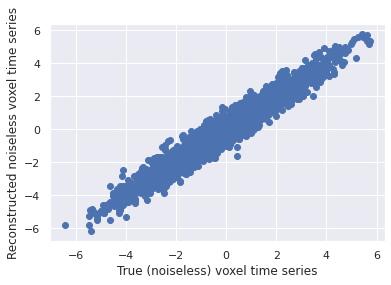

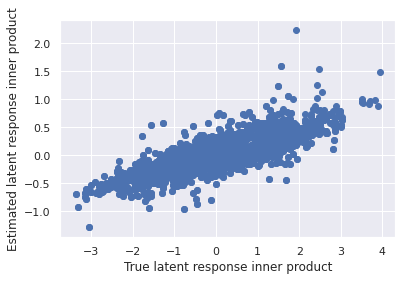

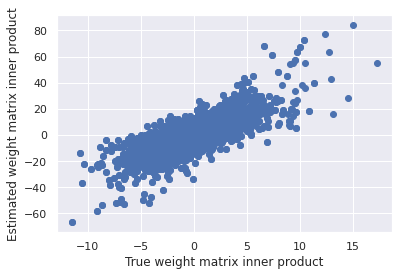

<IPython.core.display.Javascript object>

In [25]:
# regular
mn_fa = MNFactorAnalysis(time_cov=time_cov, space_cov=space_cov, n_features=components, dual=False)

mn_fa.fit(Y_tf, naive_init=False)

plt.plot((S @ B).flatten(),(mn_fa.S_ @ mn_fa.B_).flatten(),  'bo')
plt.xlabel("True (noiseless) voxel time series")
plt.ylabel("Reconstructed noiseless voxel time series")

plt.figure()
plt.plot( (S @ S.T).flatten(),(mn_fa.S_ @ mn_fa.S_.T).flatten(), 'bo')
plt.xlabel("True latent response inner product")
plt.ylabel("Estimated latent response inner product")

plt.figure()
plt.plot( (B.T @ B).flatten(), (mn_fa.B_.T @ mn_fa.B_ ).flatten(),'bo')
plt.xlabel("True weight matrix inner product")
plt.ylabel("Estimated weight matrix inner product")


Text(0, 0.5, 'Estimated weight matrix inner product')

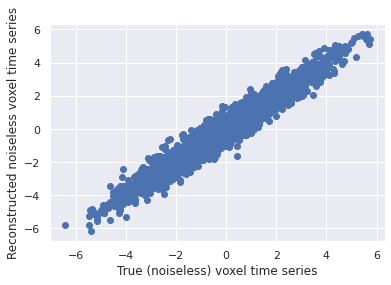

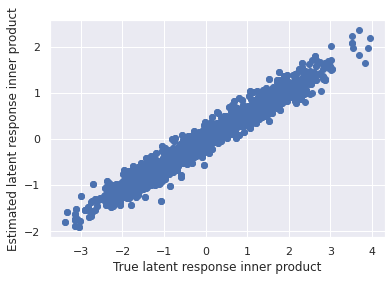

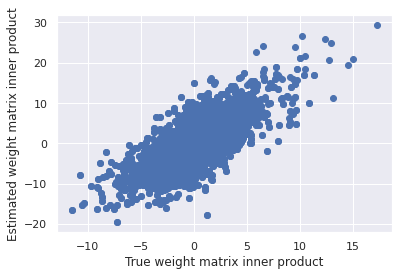

<IPython.core.display.Javascript object>

In [26]:
# Dual, integrating the other way
mn_fa = MNFactorAnalysis(time_cov=time_cov, space_cov=space_cov, n_features=components, dual=True)

mn_fa.fit(Y_tf, naive_init=False)

plt.plot((S @ B).flatten(),(mn_fa.S_ @ mn_fa.B_).flatten(),  'bo')
plt.xlabel("True (noiseless) voxel time series")
plt.ylabel("Reconstructed noiseless voxel time series")

plt.figure()
plt.plot( (S @ S.T).flatten(),(mn_fa.S_ @ mn_fa.S_.T).flatten(), 'bo')
plt.xlabel("True latent response inner product")
plt.ylabel("Estimated latent response inner product")

plt.figure()
plt.plot( (B.T @ B).flatten(), (mn_fa.B_.T @ mn_fa.B_ ).flatten(),'bo')
plt.xlabel("True weight matrix inner product")
plt.ylabel("Estimated weight matrix inner product")


<a id="Summary"></a>
## Summary

This demonstrates how `brainiak.matnormal` supports prototyping of models with kronecker-separable residuals. Again we highlight that while the specific model variants here can be implemented more efficiently, the shared and consistent framing provided by the matrix-normal framework can allow us to showcase the similarity across methods, as well as introduce a consistent idea (e.g. a particular residual structure) to different models in a consistent way. 

We invite further contributions and suggestions in helping us use `brainiak.matnormal` to blur the lines between methods-developer and methods-user. 